<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import os 
import time
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display


In [3]:
tf.__version__, tf.test.gpu_device_name()

('2.8.0', '/device:GPU:0')

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/Shareddrives/Capstone/
!ls -art

Mounted at /content/drive
/content/drive/Shareddrives/Capstone
cryptopunks.zip		   mutant-ape-yacht-club128.npz
mutant-ape-yacht-club.zip  cryptopunks.npz
mutant-ape-yacht-club	   mutant-ape-yacht-club.npz
cryptopunks		   output
cryptopunks32.npz	   NFT-metadata
output-3-11


### load pre-processed dataset

In [7]:
# load pre-processed dataset
def loadDataset(collection, batch_size, buffer_size):
  np_data = np.load(collection + '.npz')['arr_0']
 
  # use TensorFlow Dataset object to hold the images, so the data can be quickly shuffled and divided into the appropriate batch sizes for training.
  train_dataset = tf.data.Dataset.from_tensor_slices(np_data).shuffle(buffer_size).batch(batch_size)

  return train_dataset

### Build the discriminator and the generator model
hyperparameter categories:
- Number of Hidden Layers and Neuron Counts
- Activation Functions
- Advanced Activation Functions
- Regularization: L1, L2, Dropout
- Batch Normalization
- Training Parameters

In [8]:
def build_generator(seed_dim):
    model = Sequential()

    # start basis of 256 tiny 4x4 images
    model.add(Dense(4*4*256,activation="relu",input_dim=seed_dim))
    model.add(LeakyReLU(alpha=0.2))  #?
    model.add(BatchNormalization())  #?
    model.add(Reshape((4,4,256)))

    # 8x8
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # 16x16
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))
   
    # 32x32
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # 64x64
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 128x128
    # model.add(UpSampling2D(size=(4, 4)))
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # Final CNN layer
    color_channel = 3 # assume color
    model.add(Conv2D(color_channel,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

# The discriminator is a CNN-based image classifier
def build_discriminator(image_shape):
    dropout_rate = 0.25
    model = Sequential()

    # using 32 filters, downsample to 64x64 assume input is 128x128
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # classify
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

### define loss function

In [9]:
# define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    # loss when predict a real image is real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # loss when predict a fake image is fake
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # generator's success is discriminator's loss when predict a fake image as real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# use Adam and the same learning rate and momentum for both generator and discriminator. 
# need to tune the learning rates and other hyperparameters for higher image resolution (GENERATE_RES>3)
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)  #1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)


### define training loop

In [10]:
# training loop

# use of tf.function causes the function to be "compiled".
@tf.function
def train_step(images, batch_size):    
  seed = tf.random.normal([batch_size, SEED_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:    
    generated_images = GENERATOR(seed, training=True)

    real_output = DISCRIMINATOR(images, training=True)
    fake_output = DISCRIMINATOR(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, GENERATOR.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, DISCRIMINATOR.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, GENERATOR.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, DISCRIMINATOR.trainable_variables))
    
  return gen_loss,disc_loss

In [11]:
def train(dataset, startepoch, epochs, batch_size, output_path = 'output/'):
  
  start = time.time()

  for epoch in range(startepoch, startepoch + epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      batchloss = train_step(image_batch, batch_size)
      # print('batch train step genloss=', batchloss[0], " discloss=", batchloss[1])
      gen_loss_list.append(batchloss[0])
      disc_loss_list.append(batchloss[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      CHECKPOINT.save(file_prefix = os.path.join(output_path, "checkpt"))

    # Produce and save images during training
    # display.clear_output(wait=True)
    output = output_path + 'image_at_epoch_{:04d}.png'.format(epoch)
    generate_and_save_images(GENERATOR, PREVIEW_SEED, output)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch}, generator_loss={g_loss},discriminator_loss={d_loss}, run_time={hms_string(epoch_elapsed)}')

  elapsed = time.time()-start
  print (f'Total training time: {hms_string(elapsed)}')

In [12]:
def generate_and_save_images(model, noise, output):
  # set`training` to False so all layers run in inference mode (batchnorm)
  generated_images = model(noise, training=False)  

  fig = plt.figure(figsize=(4, 4))
  for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i+1)            
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(output)
  plt.show()

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_models(GENERATOR, DISCRIMINATOR):
  # save entire model to HDF5 (save everything)
  # GENERATOR.compile(metrics=[custom_metrics])  
  # GENERATOR.save(os.path.join('output',"generator.h5"))  
  # DISCRIMINATOR.save(os.path.join('output',"discriminator.h5"))
  GENERATOR.save('output/generator')
  DISCRIMINATOR.save('output/discriminator')

def load_pretrained_models():
  # load_weights?
  from tensorflow.keras.models import load_model
  GENERATOR = load_model(os.path.join('output',"generator.h5"))
  DISCRIMINATOR = load_model(os.path.join('output',"discriminator.h5"))

  return GENERATOR, DISCRIMINATOR

# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('output/image_at_epoch_{:04d}.png'.format(epoch_no))


### Parameters and training

In [13]:
BATCH_SIZE = 32  # BATCH_SIZE = 256  # colab crashed
BUFFER_SIZE = 60000

# train_dataset = loadDataset('cryptopunks32', BATCH_SIZE, BUFFER_SIZE)  # 32x32
train_dataset = loadDataset('mutant-ape-yacht-club', BATCH_SIZE, BUFFER_SIZE)  #128 x 128

iterator = iter(train_dataset)
iterator.get_next().shape  # TensorShape([32, 128, 128, 4])
# iterator.get_next()

TensorShape([32, 128, 128, 3])

tf.Tensor([[0.49971005]], shape=(1, 1), dtype=float32)


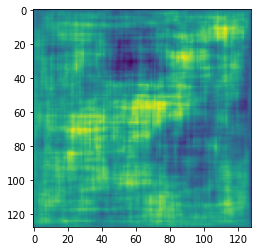

In [15]:
EPOCHS = 100 #50

IMAGE_SHAPE = (128, 128, 3)  # generated image resolution and channel, 128 is the highest for CoLab (with GPU)
SEED_DIM = 100  # Size vector to generate images from
num_examples_to_generate = 16 # min_ndim=2 layer 12?
# You will reuse this seed overtime (so it's easier) to visualize progress
PREVIEW_SEED = tf.random.normal([num_examples_to_generate, SEED_DIM])
# seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_DIM))

# models
GENERATOR = build_generator(SEED_DIM)
DISCRIMINATOR = build_discriminator(IMAGE_SHAPE)

# an initial view
noise = tf.random.normal([1, SEED_DIM])
generated_image = GENERATOR(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

decision = DISCRIMINATOR(generated_image)
print (decision)

In [16]:
CHECKPOINT = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=GENERATOR,
                                 discriminator=DISCRIMINATOR)

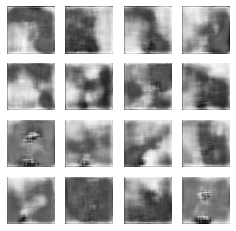

Epoch 0, generator_loss=5.466939926147461,discriminator_loss=0.10553478449583054, run_time=0:02:26.56


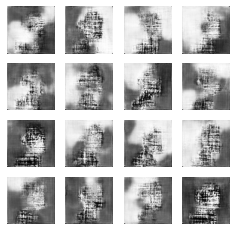

Epoch 1, generator_loss=7.1121087074279785,discriminator_loss=0.19188804924488068, run_time=0:02:22.01


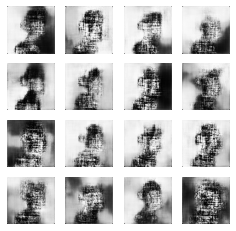

Epoch 2, generator_loss=7.482362270355225,discriminator_loss=0.3110084533691406, run_time=0:02:23.01


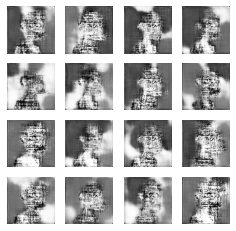

Epoch 3, generator_loss=8.620553970336914,discriminator_loss=0.4209970235824585, run_time=0:02:22.36


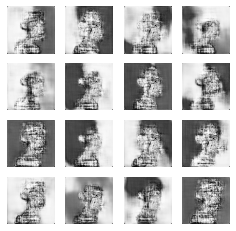

Epoch 4, generator_loss=7.8720479011535645,discriminator_loss=0.4766392707824707, run_time=0:02:21.99


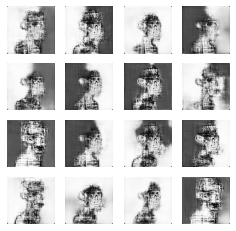

Epoch 5, generator_loss=7.882065296173096,discriminator_loss=0.4206184148788452, run_time=0:02:22.14


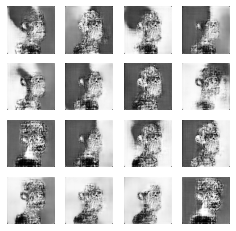

Epoch 6, generator_loss=8.13990306854248,discriminator_loss=0.37703752517700195, run_time=0:02:22.24


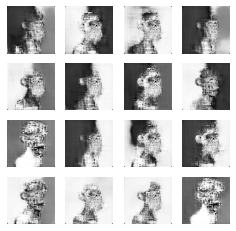

Epoch 7, generator_loss=8.752043724060059,discriminator_loss=0.3113674819469452, run_time=0:02:22.21


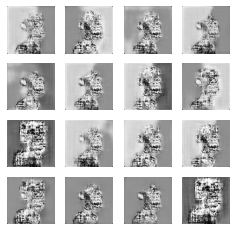

Epoch 8, generator_loss=10.5404691696167,discriminator_loss=0.3569982647895813, run_time=0:02:21.86


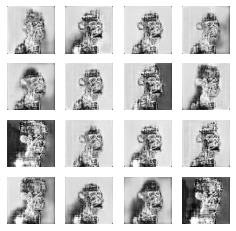

Epoch 9, generator_loss=13.012718200683594,discriminator_loss=0.2630683183670044, run_time=0:02:22.20


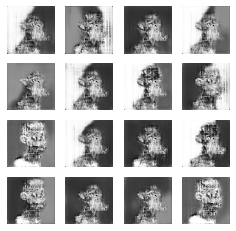

Epoch 10, generator_loss=13.427827835083008,discriminator_loss=0.31770917773246765, run_time=0:02:22.20


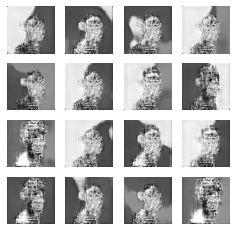

Epoch 11, generator_loss=12.191182136535645,discriminator_loss=0.38493430614471436, run_time=0:02:22.07


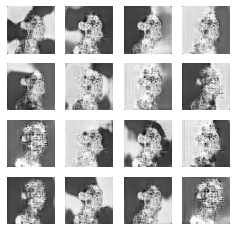

Epoch 12, generator_loss=11.100707054138184,discriminator_loss=0.5301646590232849, run_time=0:02:22.04


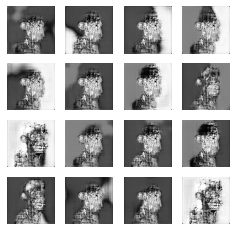

Epoch 13, generator_loss=12.269049644470215,discriminator_loss=0.4098455607891083, run_time=0:02:22.63


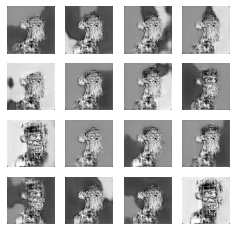

Epoch 14, generator_loss=12.923274993896484,discriminator_loss=0.29031118750572205, run_time=0:02:22.99


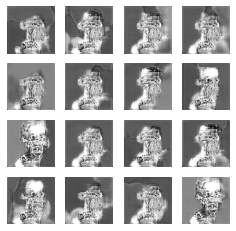

Epoch 15, generator_loss=13.9907865524292,discriminator_loss=0.17670220136642456, run_time=0:02:21.90


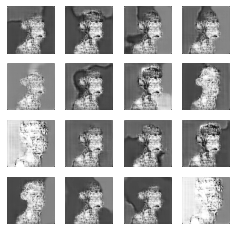

Epoch 16, generator_loss=12.520988464355469,discriminator_loss=0.2888645827770233, run_time=0:02:21.90


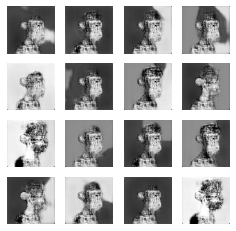

Epoch 17, generator_loss=15.900484085083008,discriminator_loss=0.3004209101200104, run_time=0:02:22.24


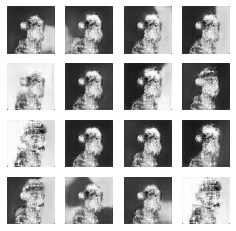

Epoch 18, generator_loss=12.58422565460205,discriminator_loss=0.4557724595069885, run_time=0:02:22.21


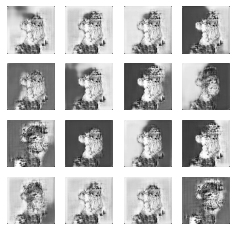

Epoch 19, generator_loss=12.886713027954102,discriminator_loss=0.3915684223175049, run_time=0:02:22.24


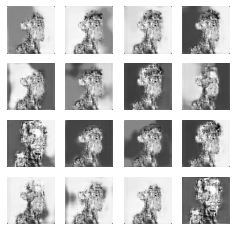

Epoch 20, generator_loss=14.817484855651855,discriminator_loss=0.29851603507995605, run_time=0:02:22.14


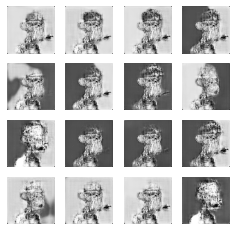

Epoch 21, generator_loss=12.600543975830078,discriminator_loss=0.5218589305877686, run_time=0:02:22.37


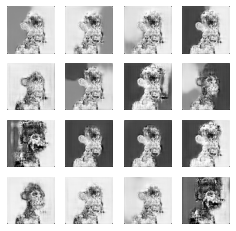

Epoch 22, generator_loss=10.080513954162598,discriminator_loss=0.32123565673828125, run_time=0:02:22.02


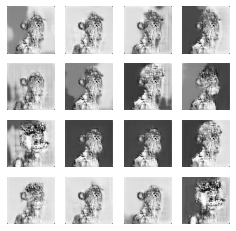

Epoch 23, generator_loss=11.890589714050293,discriminator_loss=0.2632752060890198, run_time=0:02:21.98


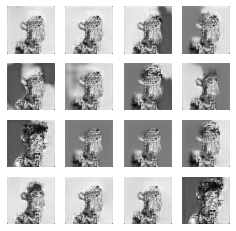

Epoch 24, generator_loss=14.068565368652344,discriminator_loss=0.334903359413147, run_time=0:02:21.83


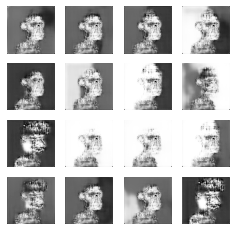

Epoch 25, generator_loss=16.056434631347656,discriminator_loss=0.22389492392539978, run_time=0:02:22.05


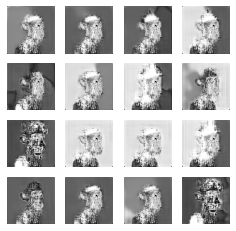

Epoch 26, generator_loss=13.263433456420898,discriminator_loss=0.2513842284679413, run_time=0:02:21.93


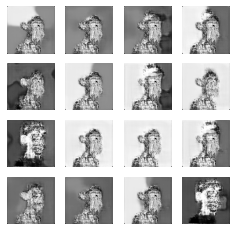

Epoch 27, generator_loss=12.43947696685791,discriminator_loss=0.18630842864513397, run_time=0:02:21.88


In [ ]:
# start training
startepoch = 0  # 0:initial training, others: continue
train(train_dataset, startepoch, EPOCHS, BATCH_SIZE)

In [ ]:
# if failed, restore the latest checkpoint
# CHECKPOINT.restore(tf.train.latest_checkpoint('output/'))

save_models(GENERATOR, DISCRIMINATOR)

In [ ]:
display_image(0)

display_image(EPOCHS-1)

tf.Tensor([[0.50008774]], shape=(1, 1), dtype=float32)


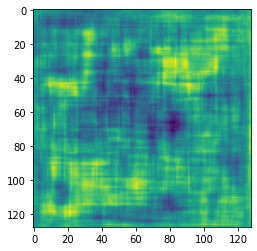

In [17]:
# reload trained models.
GENERATOR, DISCRIMINATOR = load_pretrained_models()

# check model's output
noise = tf.random.normal([1, SEED_DIM])
generated_image = GENERATOR(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

decision = DISCRIMINATOR(generated_image)
print (decision)

In [18]:
# continue to train
# startepoch = 50
# train(train_dataset, startepoch, EPOCHS, BATCH_SIZE, SEED_DIM)